In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



class Block(nn.Module):
    """A basic block used to build ResNet."""

    def __init__(self, num_channels):
        """Initializing a building block for ResNet.

        Argument:
            num_channels: the number of channels of the input to Block, and is also
                          the number of channels of conv layers of Block.
        """
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels,num_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
        

    def forward(self, x):
        """
        The input will have shape (N, num_channels, H, W),
        where N is the batch size, and H and W give the shape of each channel.

        The output should have the same shape as input.
        """
        identity = x
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + identity
        x = self.relu(x)
        return x
        


class ResNet(nn.Module):
    """A simplified ResNet."""

    def __init__(self, num_channels, num_classes=10):
        """Initializing a shallow ResNet.

        Arguments:
            num_channels: the number of output channels of the conv layer
                          before the building block, and also 
                          the number of channels of the building block.
            num_classes: the number of output units.
        """
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size = 3, stride = 2, padding= 1, bias = False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.main_block = Block(num_channels)
        self.adapavgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fullyconnected = nn.Linear(num_channels,10)
        
        
    def forward(self, x):
        """
        The input will have shape (N, 1, H, W),
        where N is the batch size, and H and W give the shape of each channel.

        The output should have shape (N, 10).
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.main_block(x)
        x = self.adapavgpool(x)
        x = x.reshape(x.shape[0],-1)
        x= self.fullyconnected(x)
        return x
        pass





In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.datasets as dset
import struct
import os

torch.manual_seed(1)

normalization = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=normalization, download=True)
test_set = dset.MNIST(root=root, train=False, transform=normalization, download=True)
trainLoader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
testLoader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=0)

net = ResNet(64)

numparams = 0
for f in net.parameters():
    print(f.size())
    numparams += f.numel()

optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=0)
optimizer.zero_grad()

criterion = nn.CrossEntropyLoss()
train_error_one,test_error_one = [],[]

def train(net, trainLoader):
    net.eval()
    correct = 0
    with torch.no_grad():
        for (data,target) in trainLoader:
            output = net(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_error_one.append((100-(100.*correct/len(trainLoader.dataset))))
        print("Train Accuracy: %f" % (100.*correct/len(trainLoader.dataset)))

train(net, trainLoader)

def test(net, testLoader):
    net.eval()
    correct = 0
    with torch.no_grad():
        for (data,target) in testLoader:
            output = net(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_error_one.append((100-(100.*correct/len(testLoader.dataset))))
        print("Test Accuracy: %f" % (100.*correct/len(testLoader.dataset)))

test(net, testLoader)

for epoch in range(2):
    net.train()
    for batch_idx, (data, target) in enumerate(trainLoader):
        pred = net(data)
        loss = criterion(pred, target)
        
        loss.backward()
        gn = 0
        for f in net.parameters():
            gn = gn + torch.norm(f.grad)
        #print("E: %d; B: %d; Loss: %f; ||g||: %f" % (epoch, batch_idx, loss, gn))
        optimizer.step()
        optimizer.zero_grad()
    test(net, testLoader)
    train(net, trainLoader)

# importing the required libraries
import matplotlib.pyplot as plt
import numpy as np

test_error_one = np.array(test_error_one)
num_array = np.array([i for i in range(len(test_error_one))])
plt.plot(test_error_one,num_array)
plt.title("Test_Error vs # of epochs")
plt.show()

train_error_one = np.array(train_error_one)
num_array_1 = np.array([i for i in range(len(train_error_one))])
plt.plot(train_error_one,num_array_1)
plt.title("Train_Error vs # of epochs")
plt.show()

torch.Size([64, 1, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
Train Accuracy: 9.930000
Test Accuracy: 10.320000
Test Accuracy: 95.950000
Train Accuracy: 95.796667
Test Accuracy: 87.790000
Train Accuracy: 87.403333


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## All the traing and test accuracy results are taken into a randomly named Excel file and used further for visualisation. 

In [ ]:
df = np.array(pd.read_excel("zdtj.xlsx",sheet_name = "Value1"))

In [ ]:
epochs = np.array([i for i in range(1,401)])

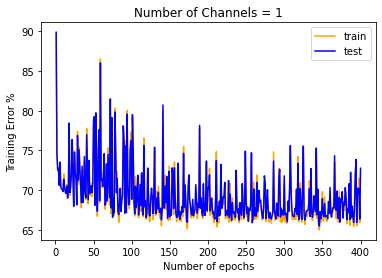

In [ ]:
plt.plot(epochs,df[:,0], color = "orange", label = "train")
plt.plot(epochs,df[:,1], color = "blue", label = "test")

plt.title("Number of Channels = 1")
plt.xlabel("Number of epochs")
plt.ylabel("Error %")
plt.ylabel("Training Error %")
plt.legend()
plt.show()

As the C value increases it means we are training the model with more features, which
means increasing the complexity of the model. So, increasing to a far extent might lead to
Overfitting the curve, where models tend to memorise the data rather than learning it.
As C increases the training error reduces because we are working on reduction in loss
function of training data. Whereas test error trend depends on the Overfitting or Underfitting of training data to the model.Here , On C = 1 the trend of training and test values are following a similar pattern and there
is no sign of Overfitting as we have only used one channel.

In [ ]:
df_2 = np.array(pd.read_excel("zdtj.xlsx",sheet_name = "Value2"))

In [ ]:
epochs = np.array([i for i in range(1,402)])

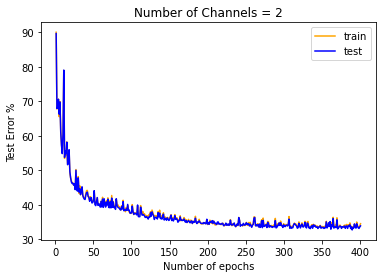

In [ ]:
plt.plot(epochs,df_2[:,0], color = "orange", label = "train")
plt.plot(epochs,df_2[:,1], color = "blue", label = "test")
plt.title("Number of Channels = 2")
plt.xlabel("Number of epochs")
plt.ylabel("Error %")
plt.ylabel("Test Error %")
plt.legend()
plt.show()

In [ ]:
df_3 = np.array(pd.read_excel("zdtj.xlsx",sheet_name = "Value4"))

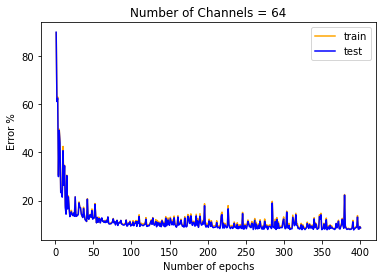

In [ ]:
plt.plot(epochs,df_3[:,0], color = "orange", label = "train")
plt.plot(epochs,df_3[:,1], color = "blue", label = "test")
plt.title("Number of Channels = 64")
plt.xlabel("Number of epochs")
plt.ylabel("Test Error %")
plt.ylabel("Error %")
plt.legend()
plt.show()

In [ ]:
df_4 = np.array(pd.read_excel("zdtj.xlsx",sheet_name = "Value64"))

In [ ]:
x = np.array([i for i in range(1,402)])

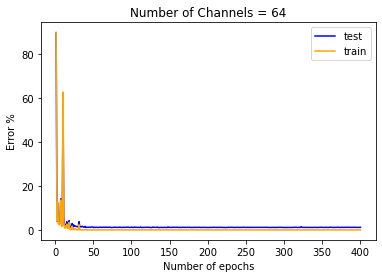

In [ ]:
plt.plot(x,df_4[:,1], color = "blue", label = "test")
plt.plot(x,df_4[:,0],color = "orange", label = "train")
plt.title("Number of Channels = 64")
plt.xlabel("Number of epochs")
plt.ylabel("Error %")
plt.legend()
plt.show()

In [ ]:
x_init = np.array([i for i in range(1,51)])

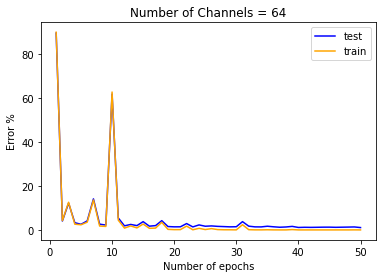

In [ ]:
plt.plot(x_init,df_4[:50,1], color = "blue", label = "test")
plt.plot(x_init,df_4[:50,0],color = "orange", label = "train")
plt.title("Number of Channels = 64")
plt.xlabel("Number of epochs")
plt.ylabel("Error %")
plt.legend()
plt.show()

As we currently have C = 64, that is our model is learning 64 different features, higher the
complexity of the model. So the model can learn the trends quickly compared to C =4. So
upon training it for more and more epochs we can see that it overfits the data. The indication
is test error keeps on increasing while training error is non-increasing, the gap between them
increases. This gap was present initially when model is learning all the features, once our
model learns them then training and test error at each epoch remains same, upon further
training it again the gap rises as test error starts to increase, because model kept trained on
train data for longer time so model cannot identify the newer observation.